**This file objective is to resampling the records to daily max-min

In [1]:
import os, ast, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_path = 'C:/Users/user/Downloads/ปริมาณสินค้าคงคลัง_ยาขาดคราว - log2 (1).csv'

In [3]:
pd.set_option('display.max_columns', None)
sns.set_theme()

In [4]:
dtypes = {
    "ProductAll":"Float64",
    "ProductRemain":"Float64",
    "ProductAllocated":"Float64"
}

In [4]:
df = pd.read_csv(csv_path, thousands=",")

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196275 entries, 0 to 196408
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ProductCode          196275 non-null  object 
 1   GenericName          196275 non-null  object 
 2   TradeName            196275 non-null  object 
 3   ProductTypeName      195735 non-null  object 
 4   ProductPricePerUnit  196275 non-null  float64
 5   ProductPrice         196275 non-null  int64  
 6   ProductStatus        196275 non-null  int64  
 7   ProductRemark        0 non-null       float64
 8   ProductUnitCode      196275 non-null  object 
 9   ProductUnitName      196275 non-null  object 
 10  ProductAll           24331 non-null   float64
 11  ProductRemain        196275 non-null  float64
 12  ProductAllocated     196275 non-null  float64
 13  LastUpdate           196275 non-null  object 
 14  enum_stock           192945 non-null  object 
 15  isRemoved            1

In [7]:
df['isRemoved'].value_counts()

isRemoved
False            132423
ปกติ              15238
FALSE              7845
ยาขาดคราว          7356
ยาใกล้ขาดคราว       961
Name: count, dtype: int64

In [8]:
df['enum_stock'].value_counts()

enum_stock
ปกติ             96461
ยาขาดคราว        70076
FALSE            21478
ยาใกล้ขาดคราว     4930
Name: count, dtype: int64

In [9]:
df['enum_stock'].value_counts()

enum_stock
ปกติ             96461
ยาขาดคราว        70076
FALSE            21478
ยาใกล้ขาดคราว     4930
Name: count, dtype: int64

<h1>Cleanse enum stock</h1>

In [10]:
df.loc[df['enum_stock'] == "FALSE", 'enum_stock'] = df.loc[df['enum_stock'] == "FALSE", 'isRemoved']

In [11]:
df.drop('isRemoved', axis=1, inplace=True)

<h1>Ensure 'LastUpdate' is a datetime object</h1>

In [12]:
df.loc[:, 'LastUpdate'] = pd.to_datetime(df['LastUpdate'])

<h1>Resample to Daily Max and Min</h1>

In [13]:
df_indexed = df.sort_values(by=['LastUpdate']).set_index('LastUpdate')

C:\Users\user\root_dir\src\envfda1\Lib\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [16]:
# Function to get the row with max ProductRemain for a given day
def get_daily_max_row(group):
    if group.empty:
        return pd.DataFrame() # Return empty if no data for the day
    return group.loc[[group['ProductRemain'].idxmax()]] # Use loc with list for single row DataFrame

# Function to get the row with min ProductRemain for a given day
def get_daily_min_row(group):
    if group.empty:
        return pd.DataFrame()
    return group.loc[[group['ProductRemain'].idxmin()]]

In [17]:
def get_daily_extrema_rows(group):
    if group.empty:
        return pd.DataFrame()
    max_row = group.loc[[group['ProductRemain'].idxmax()]].copy()
    min_row = group.loc[[group['ProductRemain'].idxmin()]].copy()
    
    # Add a column to identify if it's the max or min row for that day
    max_row['ExtremaType'] = 'Max'
    min_row['ExtremaType'] = 'Min'
    
    # Handle the case where max and min are the same row (e.g., only one entry for the day)
    # We only want one row if they are identical
    if max_row.equals(min_row):
        return max_row
    else:
        return pd.concat([max_row, min_row])

In [18]:
# Group by day and apply the functions
daily_max_df = df_indexed.groupby(pd.Grouper(freq='D')).apply(get_daily_max_row)
daily_min_df = df_indexed.groupby(pd.Grouper(freq='D')).apply(get_daily_min_row)

In [19]:
combined_daily_extrema = df_indexed.groupby(pd.Grouper(freq='D')).apply(get_daily_extrema_rows)

In [20]:
combined_daily_extrema = combined_daily_extrema.reset_index(level=0, drop=True) # Clean up index

In [21]:
df2 = combined_daily_extrema.reset_index().sort_values(by=['LastUpdate','GenericName'])

In [22]:
df2

,LastUpdate,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,ProductAll,ProductRemain,ProductAllocated,enum_stock,ExtremaType
76,2024-10-07 11:22:48,DF49B681-A53E-4350-B016-0BBA27FE66BC,Acetic Anhydride,Acetic Anhydride,NaN,2500.00,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,350.0,0.0,NaN,Max
166,2024-10-07 11:22:48,DF49B681-A53E-4350-B016-0BBA27FE66BC,Acetic Anhydride,Acetic Anhydride,NaN,2500.00,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,350.0,0.0,NaN,Min
24,2024-10-07 11:22:48,453306DE-B065-4155-9907-1A7B06F59378,Acetyl chloride,Acetyl chloride (25 ml/bot),NaN,1752.66,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,0.0,0.0,NaN,Max
114,2024-10-07 11:22:48,453306DE-B065-4155-9907-1A7B06F59378,Acetyl chloride,Acetyl chloride (25 ml/bot),NaN,1752.66,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,0.0,0.0,NaN,Min
65,2024-10-07 11:22:48,B80BA0BE-6147-41C3-B165-DFA84553E24E,Alprazolam (Standard),"Alprazolam CIV (200 mg, USP Ref std)",NaN,33216.28,0,0,NaN,12851F47-6355-4DEF-82BC-578C16E4ED41,vial,NaN,1.0,0.0,NaN,Max
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36006,2025-07-29 00:15:13,FC71BAE4-B40F-4B33-A3B9-CC3EBF23C373,Pseudoephedrine HCl tablets 30 mg,Pseudoephedrine HCl tablets 30 mg (1000 tab/box),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,505.00,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,307.0,282.0,25.0,ปกติ,Min
35904,2025-07-29 00:15:13,3E8A1259-65AC-44B1-A3C0-23DBCE8DFBFE,Pseudoephedrine HCl tablets 60 mg,Pseudoephedrine HCl tablets 60 mg (1000 tab/box),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,660.00,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,5833.0,5530.0,303.0,ปกติ,Max
35964,2025-07-29 00:15:13,3E8A1259-65AC-44B1-A3C0-23DBCE8DFBFE,Pseudoephedrine HCl tablets 60 mg,Pseudoephedrine HCl tablets 60 mg (1000 tab/box),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,660.00,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,5833.0,5530.0,303.0,ปกติ,Min
35905,2025-07-29 00:15:13,40CC4C8C-AAFA-4721-8AE2-EDEA1CFA63D9,Zolpidem tartrate tablet 10 mg/tab,"Zolpidem 10 mg tab (Zydus,India) (20 tab/box)",(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.00,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,18033.0,13682.0,4351.0,ปกติ,Max


In [19]:
df2['TradeName'].value_counts()

TradeName
Midazolam-Hameln inj 15 mg/3 ml (Siam Bioscience) (5 amp/box)    592
Methadone HCl oral concentrate solution 10 mg/ml (450 ml/bot)    592
Targin 10/5 mg tablets (28 tab/box)                              592
Concerta tablets 18 mg (30 tab/bot)                              592
Concerta tablets 36 mg (30 tab/bot)                              592
                                                                ... 
Nitrazepam (100 mg, BP Ref std)                                   52
Opium Tincture 1% ( 41%-46% Ethanol)                              52
Opium Tincture 1% ( 17%-21% Alcohol )                             52
Pseudoephedrine HCl powder (Malladi, India) (gram)                50
Ritalin LA 20 mg                                                  46
Name: count, Length: 99, dtype: int64

In [14]:
grouped_resampled = df_indexed.groupby('ProductCode').resample('D')

In [15]:
df_indexed

,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,ProductAll,ProductRemain,ProductAllocated,enum_stock
LastUpdate,,,,,,,,,,,,,,
2024-10-07 11:22:48,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,Pethidine HCl injection 50 mg/ml/amp,Pethidine HCl inj. 50 mg/ml/amp (10 amp/box),NaN,80.00000,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,25095.0,518.0,NaN
2024-10-07 11:22:48,B80BA0BE-6147-41C3-B165-DFA84553E24E,Alprazolam (Standard),"Alprazolam CIV (200 mg, USP Ref std)",NaN,33216.28000,0,0,NaN,12851F47-6355-4DEF-82BC-578C16E4ED41,vial,NaN,1.0,0.0,NaN
2024-10-07 11:22:48,B159F070-864B-4B8A-806A-A5A5CA20B72E,Pseudoephedrine HCl powder,"Pseudoephedrine HCl powder (EMBIO, india)",NaN,4492.00000,0,0,NaN,0DB401C5-F370-4B77-B305-0F45635B636C,kilogram,NaN,0.0,0.0,NaN
2024-10-07 11:22:48,AFAA7BDC-D320-46EA-BA62-D516E270D2BD,Pethidine HCl powder,"Pethidine HCl powder (Saneca, Slovakia) (kg)",NaN,20054.48000,0,0,NaN,0DB401C5-F370-4B77-B305-0F45635B636C,kilogram,NaN,0.0,0.0,NaN
2024-10-07 11:22:48,AFA80EF2-C80C-4B45-9B85-13A8875A9A7B,Morphine sulfate oral solution 10 mg/5 ml,Morphine solution 10 mg/5 ml (60 ml/bot),NaN,50.00000,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,0.0,2721.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-29 14:15:10,77487114-F588-4EFA-88A9-099A2DD55702,Ephedrine HCI powder,"Ephedrine HCI powder 100 g (Malladi, India)",(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,700.00000,0,0,NaN,96031D05-307B-413C-B767-0C1AD1816FDE,Can,0.0,0.0,0.0,ยาขาดคราว
2025-07-29 14:15:10,779D4597-C1C2-44A8-BB3B-458417180FEE,Phentermine resinate capsules 15 mg,Duromine 15 mg (30 cap/box),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,400.00000,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,0.0,0.0,0.0,ยาขาดคราว
2025-07-29 14:15:10,77CE04AB-88E1-49A2-8B69-4809069146E9,Morphine sulfate sustained release capsules 50 mg,Kapanol capsules 50 mg (28 cap/box),(ยส. 2) ยาเสพติดให้โทษในประเภท 2,1420.00000,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,0.0,0.0,0.0,ยาขาดคราว


In [ ]:
df_indexed.loc[df_indexed['']]

In [15]:
df_daily_max_custom = grouped_resampled.agg({
    'ProductRemain': 'max'
})

In [16]:
df_daily_max_custom.reset_index()

,ProductCode,LastUpdate,ProductRemain
0,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,2024-10-07,25095.0
1,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,2024-10-08,25019.0
2,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,2024-10-09,24548.0
3,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,2024-10-10,23991.0
4,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,2024-10-11,23748.0
...,...,...,...
18074,fae155f3-1909-469c-ae8f-01a35bdd3b0a,2025-06-14,0.0
18075,fae155f3-1909-469c-ae8f-01a35bdd3b0a,2025-06-15,0.0
18076,fae155f3-1909-469c-ae8f-01a35bdd3b0a,2025-06-16,0.0
18077,fae155f3-1909-469c-ae8f-01a35bdd3b0a,2025-06-17,0.0


<h1> Using loop approach for more control</h1>

In [16]:
def get_row_for_daily_max(group):
    # If there are multiple rows with the same max value, this picks the first one
    return group.loc[group['ProductRemain'].idxmax()]

In [17]:
enum_name_test = df_indexed['ProductCode'].value_counts()
enum_name_test.index.tolist()

['097EBCD3-0F75-4AC0-98AA-A33B8AED586B',
 '7C5C82A2-7C77-44DC-A562-7CC4C0E7F33D',
 'D293AE7C-6DD0-454D-9A05-46198ADB74B4',
 '7D8A86A4-7759-455E-A542-376B4D51A5EC',
 '3596649C-1D05-4E90-AFA9-952B417E12E8',
 '3081DCEA-C349-4933-A5C3-7CCEAF4A2DE1',
 '2C9E68BB-DED0-4F45-AB39-CE75996B9875',
 '2B4B64DA-8F3D-465E-8AB6-5CF1155B0F25',
 '28FFCEF4-7098-405E-9037-E905D4D4B3A1',
 '20024DAC-0DDE-48EF-B5B8-66BD529C1337',
 '1C757FC0-8FC3-4103-AA3F-B98D638551AD',
 '1AC8793E-6A02-44D5-A9A3-85A86CCEEDB0',
 '140B3711-DB0E-43D7-A2E7-A002AEB87C07',
 '0BC3546E-4F92-4F15-AEE4-07B4F24F26E8',
 '8004A1EF-E908-40D5-85FE-7F6F17D9C0CC',
 '3E8A1259-65AC-44B1-A3C0-23DBCE8DFBFE',
 '7D18E35E-5F51-4E76-BE95-EFF080136D45',
 'E39A3717-DB1A-49A7-B290-3EFD81984D7F',
 '40CC4C8C-AAFA-4721-8AE2-EDEA1CFA63D9',
 '77CE04AB-88E1-49A2-8B69-4809069146E9',
 '779D4597-C1C2-44A8-BB3B-458417180FEE',
 '77487114-F588-4EFA-88A9-099A2DD55702',
 '768645F7-8646-494D-A4F4-C853EF595DC3',
 '6F5A22E0-68F2-4734-A4B2-02F24155D291',
 '733AC742-60DA-

In [18]:
def resam_daily_max(idx_df, name_col):
    output_df = pd.DataFrame()
    enum_name = idx_df['ProductCode'].value_counts().index.tolist()
    for product_code in enum_name :
        filtered_df = idx_df.loc[idx_df[name_col] == product_code]
        df_daily_max_rows = filtered_df.groupby(filtered_df.index.date).apply(get_row_for_daily_max)
        output_df = pd.concat([output_df,df_daily_max_rows])
    return output_df

In [22]:
piv = df_indexed['TradeName'].value_counts().reset_index()

In [26]:
piv.loc[piv['TradeName'].str.contains('Alprazolam', case=False)]

,TradeName,count
5,Alprazolam tablets 0.25 mg (Polipharm),3229
28,Alprazolam tablet 1.0 mg (Polipharm) (100 tab/...,3229
44,Alprazolam tablets 0.5 mg (Polipharm),3229
66,"Alprazolam CIV (200 mg, USP Ref std)",265


In [27]:
piv.iloc[5,0]

'Alprazolam tablets 0.25 mg (Polipharm)'

In [28]:
alp_tname1 = piv.iloc[5,0]

In [ ]:
df_indexed.loc[df_indexed['TradeName'] == 'Concerta tablets 18 mg (30 tab/bot)']

In [29]:
# df_mpd18mg = df2.loc[df2['GenericName'] == 'Methylphenidate HCl extended release tablets 18 mg']
df_mpd18mg = df_indexed.loc[df_indexed['TradeName'] == alp_tname1]

In [30]:
resam_d = resam_daily_max(df_indexed, 'ProductCode')

In [31]:
resam_df = resam_d.reset_index().rename({'index':'LastUpdate'}, axis=1)

In [32]:
resam_df

,LastUpdate,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,ProductAll,ProductRemain,ProductAllocated,enum_stock
0,2024-10-07,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,Pethidine HCl injection 50 mg/ml/amp,Pethidine HCl inj. 50 mg/ml/amp (10 amp/box),NaN,80.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,25095.0,518.0,NaN
1,2024-10-08,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,Pethidine HCl injection 50 mg/ml/amp,Pethidine HCl inj. 50 mg/ml/amp (10 amp/box),(ยส. 2) ยาเสพติดให้โทษในประเภท 2,80.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,25019.0,485.0,NaN
2,2024-10-09,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,Pethidine HCl injection 50 mg/ml/amp,Pethidine HCl inj. 50 mg/ml/amp (10 amp/box),(ยส. 2) ยาเสพติดให้โทษในประเภท 2,80.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,24548.0,589.0,ปกติ
3,2024-10-10,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,Pethidine HCl injection 50 mg/ml/amp,Pethidine HCl inj. 50 mg/ml/amp (10 amp/box),(ยส. 2) ยาเสพติดให้โทษในประเภท 2,80.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,23991.0,779.0,ปกติ
4,2024-10-11,097EBCD3-0F75-4AC0-98AA-A33B8AED586B,Pethidine HCl injection 50 mg/ml/amp,Pethidine HCl inj. 50 mg/ml/amp (10 amp/box),(ยส. 2) ยาเสพติดให้โทษในประเภท 2,80.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,23748.0,700.0,ปกติ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18011,2024-10-25,AE433AC9-A861-4BBE-A0D8-346CC1ADAF4D,Methylphenidate HCl modified release hard caps...,Ritalin LA 20 mg,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,1200.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,0.0,0.0,ยาขาดคราว
18012,2024-10-26,AE433AC9-A861-4BBE-A0D8-346CC1ADAF4D,Methylphenidate HCl modified release hard caps...,Ritalin LA 20 mg,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,1200.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,0.0,0.0,ยาขาดคราว
18013,2024-10-27,AE433AC9-A861-4BBE-A0D8-346CC1ADAF4D,Methylphenidate HCl modified release hard caps...,Ritalin LA 20 mg,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,1200.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,0.0,0.0,ยาขาดคราว
18014,2024-10-28,AE433AC9-A861-4BBE-A0D8-346CC1ADAF4D,Methylphenidate HCl modified release hard caps...,Ritalin LA 20 mg,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,1200.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,NaN,0.0,0.0,ยาขาดคราว


Text(0.5, 0, 'Timestamp')

C:\Users\user\root_dir\src\envfda1\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3650 (\N{THAI CHARACTER SARA O}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\root_dir\src\envfda1\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\root_dir\src\envfda1\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\root_dir\src\envfda1\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\root_dir\src\envfda1\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\root_dir\src\envfda1\Lib\site-packages\IPython\core\events.py:82: UserWar

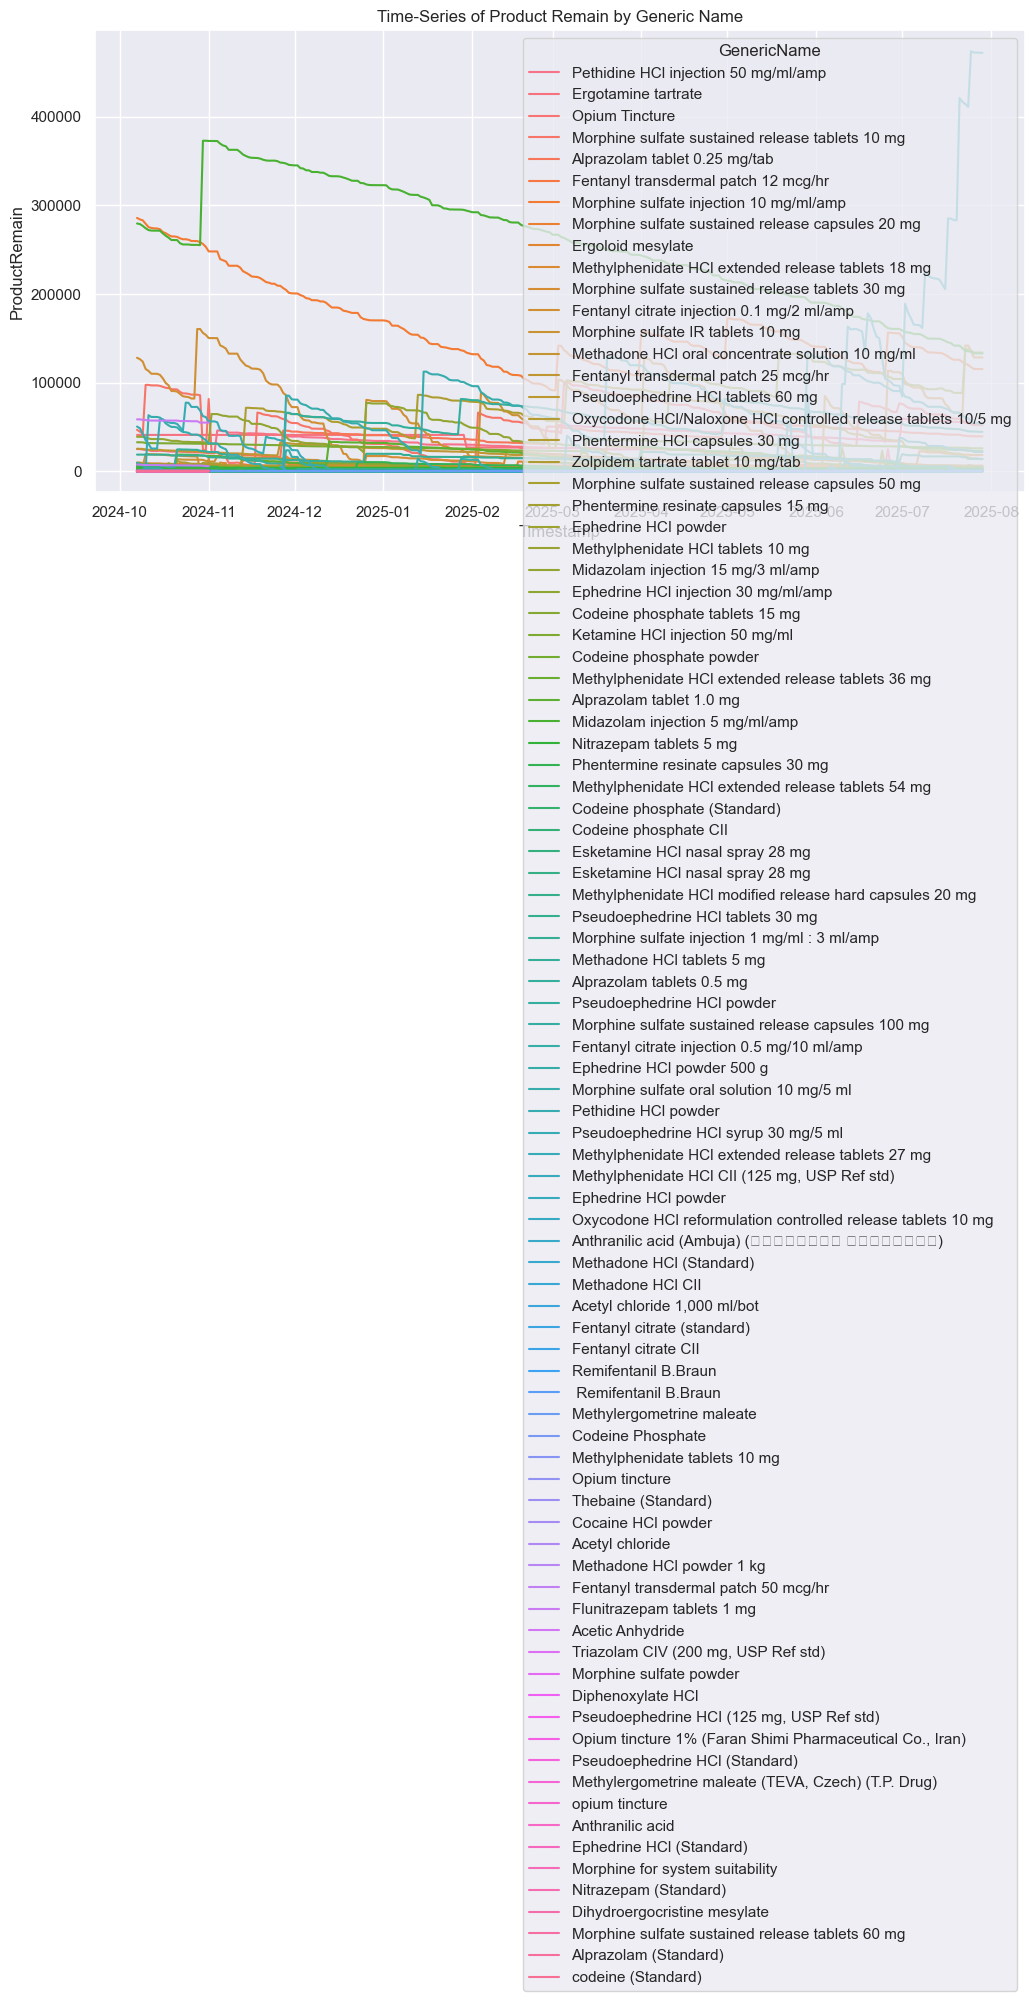

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=resam_df,
             x='LastUpdate',
             y='ProductRemain',
             hue='GenericName',
             # marker='o',
             errorbar=None)
plt.title('Time-Series of Product Remain by Generic Name')
plt.xlabel('Timestamp')

In [37]:
summed_value_per_timestamp = resam_df.groupby(by=['LastUpdate'])['ProductRemain'].sum().reset_index()

In [36]:
summed_value_per_timestamp.reset_index()

,LastUpdate,ProductRemain
0,2024-10-07,1167669.0
1,2024-10-08,1163303.0
2,2024-10-09,1145428.0
3,2024-10-10,1197740.0
4,2024-10-11,1249017.0
...,...,...
291,2025-07-25,1428488.0
292,2025-07-26,1402869.0
293,2025-07-27,1402629.0
294,2025-07-28,1400072.0


Text(0, 0.5, 'Unit(s)')

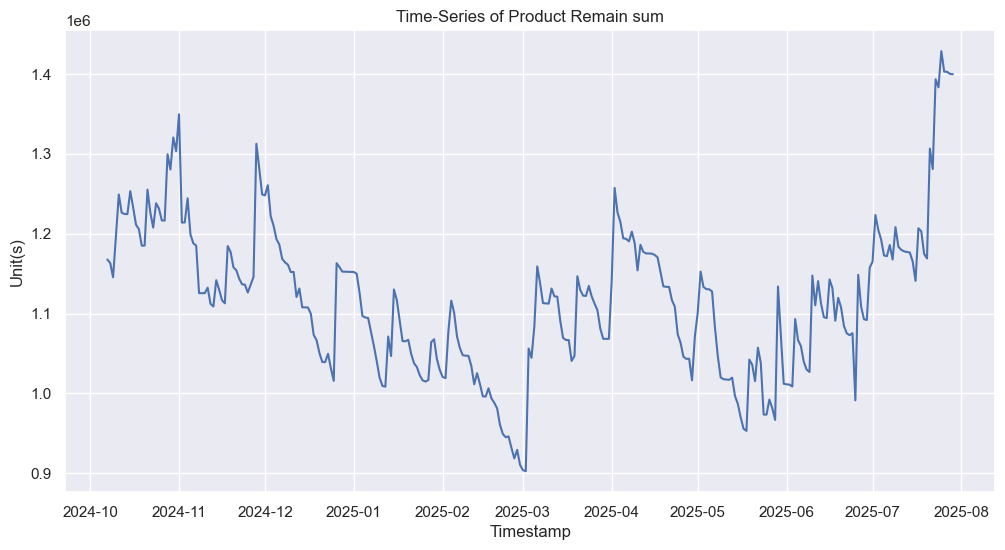

In [38]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=summed_value_per_timestamp,
             x='LastUpdate',
             y='ProductRemain',
             # hue='GenericName',
             # marker='o',
             errorbar=None)
plt.title('Time-Series of Product Remain sum')
plt.xlabel('Timestamp')
plt.ylabel('Unit(s)')

In [39]:
resam_df.to_csv('C:/Users/user/Downloads/nrf_invent_max_redis2025-07-31.csv',encoding='utf-8')

In [33]:
df_daily_max_rows = df_mpd18mg.groupby(df_mpd18mg.index.date).apply(get_row_for_daily_max)

In [34]:
df_daily_max_rows.reset_index()

,index,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,ProductAll,ProductRemain,ProductAllocated,enum_stock
0,2024-10-07,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),NaN,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,NaN
1,2024-10-08,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,NaN
2,2024-10-09,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,ยาขาดคราว
3,2024-10-10,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,3340.0,4320.0,ปกติ
4,2024-10-11,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,3217.0,4443.0,ปกติ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2025-07-25,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,40631.0,39623.0,1008.0,ปกติ
292,2025-07-26,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,39897.0,39416.0,481.0,ปกติ
293,2025-07-27,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,39897.0,39416.0,481.0,ปกติ
294,2025-07-28,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,39897.0,39416.0,481.0,ปกติ


In [36]:
df.loc[df['TradeName'] == alp_tname1].sort_values(by='ProductRemain',ascending=False)

,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,ProductAll,ProductRemain,ProductAllocated,LastUpdate,enum_stock
132389,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,56580.0,84.0,2025-04-30 18:15:01,ปกติ
132625,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,56580.0,84.0,2025-05-01 02:15:02,ปกติ
132802,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,56580.0,84.0,2025-05-01 08:15:01,ปกติ
132743,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,56580.0,84.0,2025-05-01 06:15:00,ปกติ
132684,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,56580.0,84.0,2025-05-01 04:15:00,ปกติ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,2024-10-09 14:14:56,ยาขาดคราว
2089,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,2024-10-09 12:15:06,ยาขาดคราว
1999,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,2024-10-09 10:14:52,ยาขาดคราว
1909,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,2024-10-09 08:14:55,ยาขาดคราว


In [37]:
df_concerta18 = df.loc[df['TradeName'] == alp_tname1].sort_values(by='LastUpdate')

In [38]:
df['ProductCode'].value_counts()

ProductCode
097EBCD3-0F75-4AC0-98AA-A33B8AED586B    3229
5B193506-F5CD-4317-8237-C43303A653C3    3229
6D9D125F-7918-43E6-A98C-9EFAD6CA21E0    3229
6F5A22E0-68F2-4734-A4B2-02F24155D291    3229
F66B4597-B645-4294-9CF5-056AFEC4C60D    3229
                                        ... 
A45F8FAC-0D10-465C-BD50-C69540536A49     265
DDB2C134-CF34-4292-8FDB-348897C0261E     265
DF49B681-A53E-4350-B016-0BBA27FE66BC     265
A3B97B18-F4DA-4E7D-924F-3B148C0E1FF4     265
AE433AC9-A861-4BBE-A0D8-346CC1ADAF4D     233
Name: count, Length: 97, dtype: int64

In [39]:
df_concerta18_resam = df_concerta18.set_index('LastUpdate')

C:\Users\user\root_dir\src\envfda1\Lib\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [40]:
df_concerta18_resam

,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,ProductAll,ProductRemain,ProductAllocated,enum_stock
LastUpdate,,,,,,,,,,,,,,
2024-10-07 11:22:48,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),NaN,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,NaN
2024-10-07 12:14:49,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),NaN,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,NaN
2024-10-07 14:14:50,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),NaN,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,NaN
2024-10-07 16:14:49,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),NaN,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,ยาขาดคราว
2024-10-07 18:14:52,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),NaN,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,NaN,0.0,200.0,ยาขาดคราว
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-29 06:15:11,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,39897.0,39416.0,481.0,ปกติ
2025-07-29 08:15:12,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,39897.0,39416.0,481.0,ปกติ
2025-07-29 10:15:13,3596649C-1D05-4E90-AFA9-952B417E12E8,Alprazolam tablet 0.25 mg/tab,Alprazolam tablets 0.25 mg (Polipharm),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,60.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,39857.0,39316.0,541.0,ปกติ


In [41]:
df_concerta18_resam2 = df_concerta18_resam['ProductRemain'].resample('D').max().reset_index()

In [42]:
df_concerta18_resam2

,LastUpdate,ProductRemain
0,2024-10-07,0.0
1,2024-10-08,0.0
2,2024-10-09,0.0
3,2024-10-10,3340.0
4,2024-10-11,3217.0
...,...,...
291,2025-07-25,39623.0
292,2025-07-26,39416.0
293,2025-07-27,39416.0
294,2025-07-28,39416.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


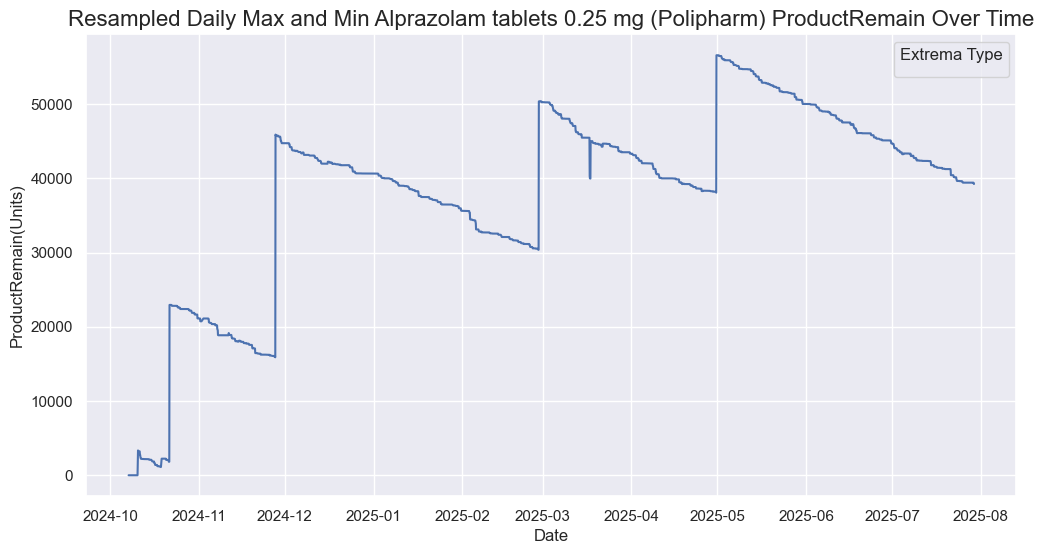

In [44]:
# Now plot the resampled data
plt.figure(figsize=(12, 6)) # Adjust figure size for better readability
sns.lineplot(
    data=df_concerta18_resam,
    x='LastUpdate',
    y='ProductRemain',
    # hue='enum_type',
    # marker='o', # Add markers for each data point
    errorbar=None
)

# Add title and labels for clarity
plt.title(f'Resampled Daily Max and Min {alp_tname1} ProductRemain Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ProductRemain(Units)', fontsize=12)
plt.legend(title='Extrema Type')

# Display the plot
plt.show()

In [ ]:
df_concerta18_resam = df_concerta18.groupby(by=['LastUpdate'])

In [25]:
name_pivot = ['ProductAll', 'ProductRemain', 'ProductAllocated']
df_concerta18_unpivot = df_concerta18.melt(
    id_vars = [col for col in df_concerta18.columns.tolist() if col not in name_pivot],
    value_vars=['ProductAll', 'ProductRemain', 'ProductAllocated'],
    var_name='enum_type',
    value_name='values'
)

In [48]:
df_concerta18_unpivot

,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,LastUpdate,enum_stock,isRemoved,enum_type,values
0,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),NaN,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2024-10-07 11:22:48,NaN,NaN,ProductAll,NaN
1,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),NaN,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2024-10-07 12:14:49,NaN,NaN,ProductAll,NaN
2,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),NaN,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2024-10-07 14:14:50,NaN,NaN,ProductAll,NaN
3,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),NaN,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2024-10-07 16:14:49,ปกติ,NaN,ProductAll,NaN
4,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),NaN,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2024-10-07 18:14:52,ยาขาดคราว,NaN,ProductAll,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9682,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2025-07-29 06:15:11,FALSE,ยาใกล้ขาดคราว,ProductAllocated,1039.0
9683,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2025-07-29 08:15:12,FALSE,ยาใกล้ขาดคราว,ProductAllocated,1039.0
9684,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2025-07-29 10:15:13,FALSE,ยาใกล้ขาดคราว,ProductAllocated,974.0
9685,A9390303-63DA-47CB-B748-A0C4CB74FCAA,Methylphenidate HCl extended release tablets 1...,Concerta tablets 18 mg (30 tab/bot),(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,2400.0,0,0,NaN,4CE8E50B-80B3-4003-B2B6-9D08C97DD814,Bottle,2025-07-29 12:15:14,FALSE,ยาใกล้ขาดคราว,ProductAllocated,974.0


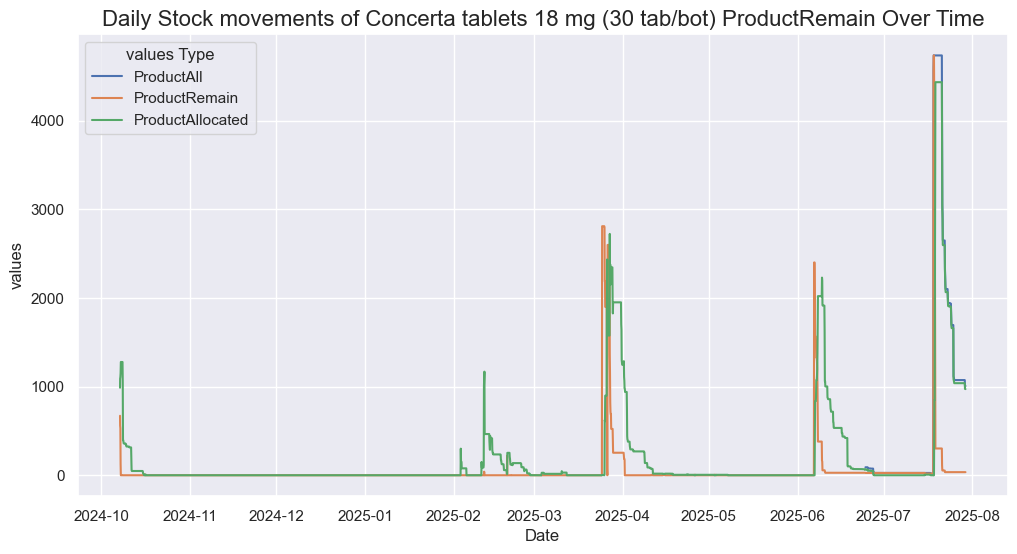

In [27]:
# Now plot the resampled data
plt.figure(figsize=(12, 6)) # Adjust figure size for better readability
sns.lineplot(
    data=df_concerta18_unpivot,
    x='LastUpdate',
    y='values',
    hue='enum_type',
    # marker='o', # Add markers for each data point
    errorbar=None
)

# Add title and labels for clarity
plt.title('Daily Stock movements of Concerta tablets 18 mg (30 tab/bot) ProductRemain Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('values', fontsize=12)
plt.legend(title='values Type')

# Display the plot
plt.show()

In [14]:
df_mid_small['deltaProductRemain'] = df_mid_small['ProductRemain'].diff().fillna(0)

In [15]:
df_mid_small.loc[df_mid_small['deltaProductRemain'] == 0]

,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,ProductRemain,ProductAllocated,LastUpdate,enum_stock,isRemoved,daylog,deltaProductRemain
0,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,NaN,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,279445,"3,511",2024-10-07 11:22:48,NaN,NaN,10/7/2024,0.0
6,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278832,"2,917",2024-10-07 22:14:49,NaN,NaN,10/7/2024,0.0
7,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278832,"2,917",2024-10-08 02:14:54,NaN,NaN,10/8/2024,0.0
8,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278832,"2,917",2024-10-08 04:14:51,NaN,NaN,10/8/2024,0.0
9,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278832,"2,917",2024-10-08 06:14:59,NaN,NaN,10/8/2024,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,171823,"7,460",2025-06-16 22:15:03,ปกติ,False,6/16/2025,0.0
2722,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,171876,"7,407",2025-06-17 02:15:04,ปกติ,False,6/17/2025,0.0
2723,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,171876,"7,407",2025-06-17 04:15:02,ปกติ,False,6/17/2025,0.0
2724,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0,0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,171876,"7,407",2025-06-17 06:15:04,ปกติ,False,6/17/2025,0.0


In [17]:
df_mid_small['deltaProductRemain_Sold'] = -df_mid_small['deltaProductRemain']

<h1> detect restock events</h1>

In [18]:
df_mid_small['deltaProductRemain_Sold'] = df_mid_small['deltaProductRemain_Sold'].apply(lambda x: x if x > 0 else 0)

In [19]:
df_mid_small = df_mid_small.loc[df_mid_small['deltaProductRemain'] != 0]

In [20]:
df_mid_small['deltaTime'] = df_mid_small['LastUpdate'].diff()

In [21]:
df_mid_small['deltaTime'] = df_mid_small['deltaTime'].fillna(pd.Timedelta(seconds=0))

In [24]:
df_mid_small['deltaTime_hours'] = df_mid_small['deltaTime'].dt.total_seconds() / 3600

In [25]:
df_mid_small.loc[0, 'deltaTime_hours'] = np.nan

In [26]:
df_mid_small['SaleRate_Per_Hour'] = df_mid_small['deltaProductRemain_Sold'] / df_mid_small['deltaTime_hours']

In [27]:
df_mid_small['SaleRate_Per_Hour'] = df_mid_small['SaleRate_Per_Hour'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [58]:
df_mid_small

,ProductCode,GenericName,TradeName,ProductTypeName,ProductPricePerUnit,ProductPrice,ProductStatus,ProductRemark,ProductUnitCode,ProductUnitName,ProductRemain,ProductAllocated,LastUpdate,enum_stock,isRemoved,daylog,deltaProductRemain,deltaProductRemain_Sold,deltaTime,deltaTime_hours,SaleRate_Per_Hour,SaleRate_Per_Hour_Interval,Date
1,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,NaN,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278945.0,"4,011",2024-10-07 12:14:49,NaN,NaN,10/7/2024,-500.0,500.0,0 days 00:00:00,0.000000,0.000000,0.000000,2024-10-07
2,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,NaN,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278898.0,"4,038",2024-10-07 14:14:50,NaN,NaN,10/7/2024,-47.0,47.0,0 days 02:00:01,2.000278,23.496737,23.496737,2024-10-07
3,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,NaN,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278867.0,"2,882",2024-10-07 16:14:49,ปกติ,NaN,10/7/2024,-31.0,31.0,0 days 01:59:59,1.999722,15.502153,15.502153,2024-10-07
4,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,NaN,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278837.0,"2,912",2024-10-07 18:14:52,ปกติ,NaN,10/7/2024,-30.0,30.0,0 days 02:00:03,2.000833,14.993753,14.993753,2024-10-07
5,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,NaN,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,278832.0,"2,917",2024-10-07 20:14:56,ปกติ,NaN,10/7/2024,-5.0,5.0,0 days 02:00:04,2.001111,2.498612,2.498612,2024-10-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,173453.0,"6,033",2025-06-16 14:15:01,ปกติ,False,6/16/2025,-23.0,23.0,0 days 03:59:56,3.998889,5.751598,5.751598,2025-06-16
2717,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,171893.0,"7,390",2025-06-16 16:15:05,ปกติ,False,6/16/2025,-1560.0,1560.0,0 days 02:00:04,2.001111,779.566907,779.566907,2025-06-16
2718,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,171823.0,"7,460",2025-06-16 18:15:05,ปกติ,False,6/16/2025,-70.0,70.0,0 days 02:00:00,2.000000,35.000000,35.000000,2025-06-16
2721,6D9D125F-7918-43E6-A98C-9EFAD6CA21E0,Midazolam injection 5 mg/ml/amp,Midazolam-Hameln inj 5 mg/ml (Siam Bioscience)...,(วจ. 2) วัตถุออกฤทธิ์ในประเภท 2,150.0,0.0,0.0,NaN,06E9F1D3-35B4-463C-B396-9D0E088B2AD0,Box,171876.0,"7,407",2025-06-17 00:15:04,ปกติ,False,6/17/2025,53.0,0.0,0 days 05:59:59,5.999722,0.000000,0.000000,2025-06-17


In [29]:
df_mid_small['SaleRate_Per_Hour_Interval'] = df_mid_small['deltaProductRemain_Sold'] / df_mid_small['deltaTime_hours']

In [30]:
df_mid_small['SaleRate_Per_Hour_Interval'] = df_mid_small['SaleRate_Per_Hour_Interval'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [42]:
df_mid_small['LastUpdate'] = pd.to_datetime(df_mid_small['LastUpdate'])

In [43]:
df_mid_small['Date'] = df_mid_small['LastUpdate'].dt.date

In [44]:
df_mid_small['LastUpdate'].dtype

dtype('<M8[ns]')

In [45]:
daily_summary = df_mid_small.groupby('Date').agg(
    TotalProductsSold=('deltaProductRemain_Sold', 'sum'),
    TotalTimeElapsedHours=('deltaTime_hours', 'sum')
).reset_index()

In [46]:
daily_summary['DailyAvgSaleRate_Per_Hour'] = daily_summary['TotalProductsSold'] / daily_summary['TotalTimeElapsedHours']

In [47]:
daily_summary['DailyAvgSaleRate_Per_Hour'] = daily_summary['DailyAvgSaleRate_Per_Hour'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [48]:
daily_summary['DailyTotalSales'] = daily_summary['TotalProductsSold']

In [51]:
daily_summary

,Date,TotalProductsSold,TotalTimeElapsedHours,DailyAvgSaleRate_Per_Hour,DailyTotalSales
0,2024-10-07,613.0,8.001944,76.606380,613.0
1,2024-10-08,2097.0,21.998333,95.325403,2097.0
2,2024-10-09,2686.0,24.000833,111.912781,2686.0
3,2024-10-10,1989.0,28.074722,70.846649,1989.0
4,2024-10-11,614.0,19.924444,30.816418,614.0
...,...,...,...,...,...
232,2025-06-13,1951.0,19.998889,97.555420,1951.0
233,2025-06-14,141.0,26.000000,5.423077,141.0
234,2025-06-15,67.0,21.999722,3.045493,67.0
235,2025-06-16,2239.0,24.000833,93.288427,2239.0


In [49]:
daily_summary.loc[daily_summary['DailyTotalSales']==0]

,Date,TotalProductsSold,TotalTimeElapsedHours,DailyAvgSaleRate_Per_Hour,DailyTotalSales
15,2024-10-23,0.0,8.000000,0.0,0.0
23,2024-11-02,0.0,25.999167,0.0,0.0
42,2024-11-23,0.0,8.002500,0.0,0.0
59,2024-12-10,0.0,10.046111,0.0,0.0
101,2025-01-25,0.0,8.001111,0.0,0.0
213,2025-05-24,0.0,4.000000,0.0,0.0
236,2025-06-17,0.0,5.999722,0.0,0.0


In [52]:
daily_summary2 = daily_summary.loc[daily_summary['DailyTotalSales']!=0]

<Axes: xlabel='Date', ylabel='DailyTotalSales'>

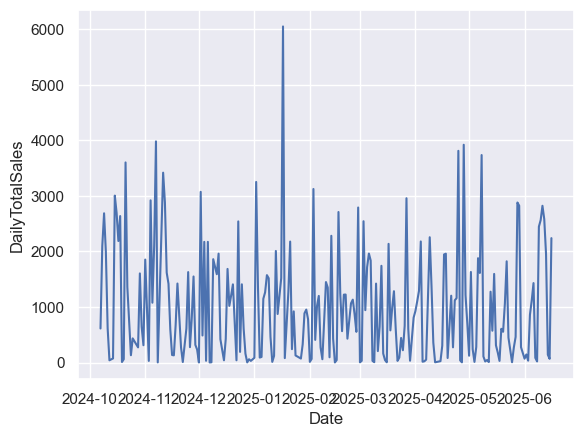

In [53]:
sns.lineplot(data=daily_summary2, x='Date', y='DailyTotalSales', errorbar=None)

In [55]:
daily_summary['DailyTotalSales'].mean()

992.7299578059071

In [57]:
daily_summary['DailyTotalSales'].std()

1038.763657066801

In [59]:
mean_daily_sale = daily_summary['DailyTotalSales'].mean()
std_daily_sale = daily_summary['DailyTotalSales'].std()

In [61]:
hours_per_day = 24
mean_hourly_sales = mean_daily_sale / hours_per_day
print(f"Mean Hourly Sales: {mean_hourly_sales:.4f} units/hour")

Mean Hourly Sales: 41.3637 units/hour


In [158]:
std_daily_sale

1038.763657066801

In [63]:
std_hourly_for_band = std_daily_sale / hours_per_day

In [163]:
print(f"Sample standard deviation: {std_hourly_for_band:.4f}")

Sample standard deviation: 43.2818


In [164]:
print(f"z_score: {z_score:.2f}")

z_score: 1.00


In [64]:
last_observed_time = df_mid_small['LastUpdate'].max()

In [126]:
extrapolation_period_days = 360

In [127]:
future_hours = extrapolation_period_days * hours_per_day

In [128]:
future_timestamps = pd.to_datetime(
    [last_observed_time + pd.Timedelta(hours=i) for i in range(1, future_hours + 1)]
)

In [129]:
extrapolated_df = pd.DataFrame({
    'LastUpdate': future_timestamps
})

In [96]:
len(df_mid_small['ProductRemain'])

935

In [99]:
df_mid_small['ProductRemain'].tail(5)

2716    173453.0
2717    171893.0
2718    171823.0
2721    171876.0
0            NaN
Name: ProductRemain, dtype: float64

In [130]:
last_product_remain = df_mid_small['ProductRemain'].iloc[len(df_mid_small['ProductRemain'])-2]

In [131]:
last_product_remain

171876.0

In [84]:
mean_hourly_sales

41.363748241912795

In [85]:
future_hours

2160

In [132]:
projected_product_remain = [last_product_remain - (mean_hourly_sales * i) for i in range(1, future_hours + 1)]

In [133]:
extrapolated_df['ProductRemain_Mean'] = projected_product_remain

In [72]:
z_score = 1

In [134]:
extrapolated_df['Cumulative_Hours_From_Last'] = (extrapolated_df['LastUpdate'] - last_observed_time).dt.total_seconds() / 3600

In [135]:
extrapolated_df['Cumulative_Days_From_Last'] = extrapolated_df['Cumulative_Hours_From_Last'] / hours_per_day

In [136]:
extrapolated_df

,LastUpdate,ProductRemain_Mean,Cumulative_Hours_From_Last,Cumulative_Days_From_Last
0,2025-06-17 01:15:04,171834.636252,1.0,0.041667
1,2025-06-17 02:15:04,171793.272504,2.0,0.083333
2,2025-06-17 03:15:04,171751.908755,3.0,0.125000
3,2025-06-17 04:15:04,171710.545007,4.0,0.166667
4,2025-06-17 05:15:04,171669.181259,5.0,0.208333
...,...,...,...,...
8635,2026-06-11 20:15:04,-185341.329817,8636.0,359.833333
8636,2026-06-11 21:15:04,-185382.693565,8637.0,359.875000
8637,2026-06-11 22:15:04,-185424.057314,8638.0,359.916667
8638,2026-06-11 23:15:04,-185465.421062,8639.0,359.958333


In [137]:
extrapolated_df['ProductRemain_Upper'] = extrapolated_df['ProductRemain_Mean'] + (z_score * std_daily_sale * np.sqrt(extrapolated_df['Cumulative_Days_From_Last']))
extrapolated_df['ProductRemain_Lower'] = extrapolated_df['ProductRemain_Mean'] - (z_score * std_daily_sale * np.sqrt(extrapolated_df['Cumulative_Days_From_Last']))

In [138]:
extrapolated_df['ProductRemain_Lower'] = extrapolated_df['ProductRemain_Lower'].clip(lower=0)
extrapolated_df['ProductRemain_Mean'] = extrapolated_df['ProductRemain_Mean'].clip(lower=0) # Cap mean at 0 too
extrapolated_df['ProductRemain_Upper'] = extrapolated_df['ProductRemain_Upper'].clip(lower=0)

In [141]:
extrapolated_df = extrapolated_df.loc[extrapolated_df['ProductRemain_Mean'] >0]

In [143]:
extrapolated_df

,LastUpdate,ProductRemain_Mean,Cumulative_Hours_From_Last,Cumulative_Days_From_Last,ProductRemain_Upper,ProductRemain_Lower
0,2025-06-17 01:15:04,171834.636252,1.0,0.041667,172046.672995,171622.599508
1,2025-06-17 02:15:04,171793.272504,2.0,0.083333,172093.137742,171493.407265
2,2025-06-17 03:15:04,171751.908755,3.0,0.125000,172119.167168,171384.650342
3,2025-06-17 04:15:04,171710.545007,4.0,0.166667,172134.618494,171286.471520
4,2025-06-17 05:15:04,171669.181259,5.0,0.208333,172143.309831,171195.052686
...,...,...,...,...,...,...
4150,2025-12-06 23:15:04,175.081048,4151.0,172.958333,13836.238364,0.000000
4151,2025-12-07 00:15:04,133.717300,4152.0,173.000000,13796.520043,0.000000
4152,2025-12-07 01:15:04,92.353551,4153.0,173.041667,13756.801523,0.000000
4153,2025-12-07 02:15:04,50.989803,4154.0,173.083333,13717.082806,0.000000


In [154]:
last_lowerProjectedDate = None
for i,row in extrapolated_df.iterrows():
    if row.loc['ProductRemain_Lower'] == 0:
        last_lowerProjectedDate = row.loc['LastUpdate']
        break

In [155]:
last_lowerProjectedDate

Timestamp('2025-11-23 22:15:04')

In [151]:
lastRemainsDate = extrapolated_df.iloc[len(extrapolated_df)-1,0]

In [152]:
lastRemainsDate

Timestamp('2025-12-07 03:15:04')

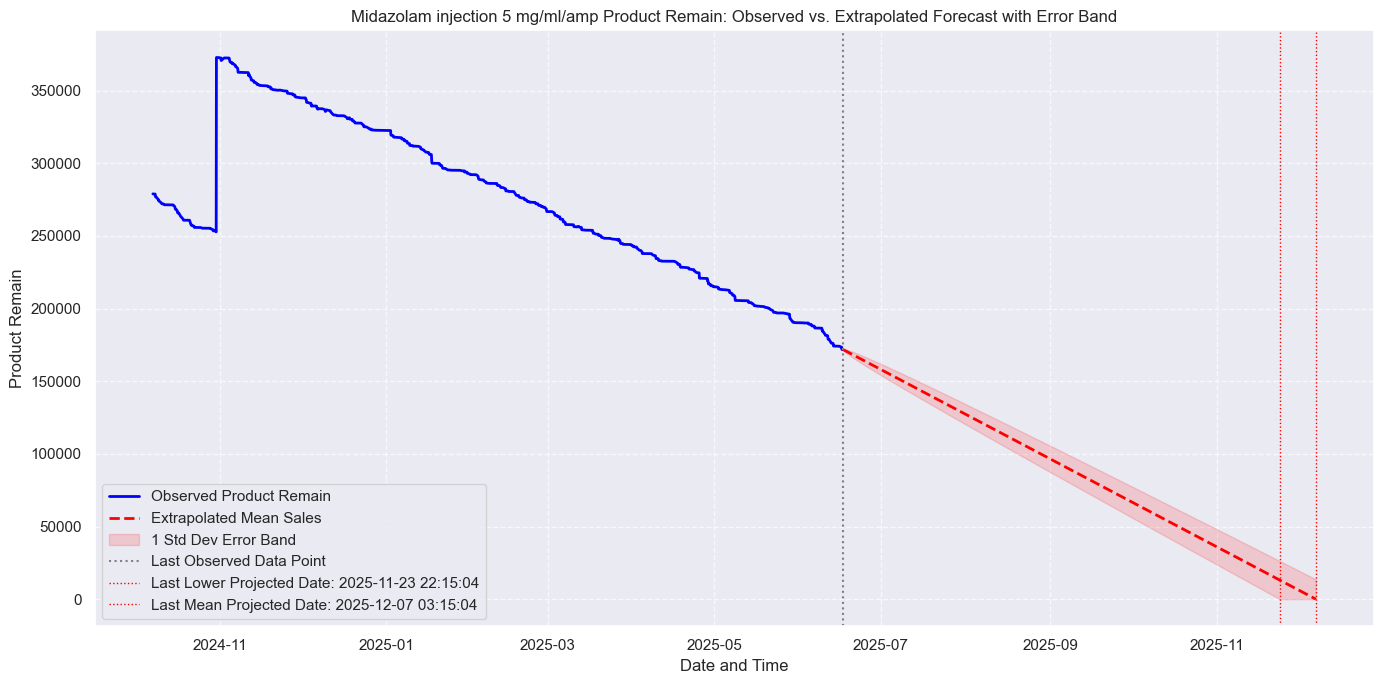

In [157]:
# Create a common column 'ProductRemain' for plotting observed data
df_observed_plot = df_mid_small[['LastUpdate', 'ProductRemain']].copy()
df_observed_plot['Type'] = 'Observed'

# Prepare extrapolated data for plotting
df_extrapolated_plot = extrapolated_df[['LastUpdate', 'ProductRemain_Mean']].copy()
df_extrapolated_plot['ProductRemain'] = df_extrapolated_plot['ProductRemain_Mean']
df_extrapolated_plot['Type'] = 'Extrapolated Mean'

# Concatenate for plotting the main lines
df_combined = pd.concat([df_observed_plot, df_extrapolated_plot])

plt.figure(figsize=(14, 7))

# Plot observed data
sns.lineplot(data=df_observed_plot, x='LastUpdate', y='ProductRemain', label='Observed Product Remain', color='blue', linewidth=2)

# Plot extrapolated mean
sns.lineplot(data=df_extrapolated_plot, x='LastUpdate', y='ProductRemain', label='Extrapolated Mean Sales', color='red', linestyle='--', linewidth=2)

# Plot the error band using fill_between
plt.fill_between(
    extrapolated_df['LastUpdate'],
    extrapolated_df['ProductRemain_Lower'],
    extrapolated_df['ProductRemain_Upper'],
    color='red',
    alpha=0.15,
    label=f'{z_score} Std Dev Error Band'
)

# Add a vertical line at the last observed point to separate observed from forecast
plt.axvline(last_observed_time, color='gray', linestyle=':', linewidth=1.5, label='Last Observed Data Point')
plt.axvline(last_lowerProjectedDate, color='red', linestyle=':', linewidth=1, label=f'Last Lower Projected Date: {last_lowerProjectedDate}')
plt.axvline(lastRemainsDate, color='red', linestyle=':', linewidth=1, label=f'Last Mean Projected Date: {lastRemainsDate}')

plt.title('Midazolam injection 5 mg/ml/amp Product Remain: Observed vs. Extrapolated Forecast with Error Band')
plt.xlabel('Date and Time')
plt.ylabel('Product Remain')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()